<div width="100%">
    <img width="100%" src="https://storage.googleapis.com/kaggle-datasets-images/1846/3197/6a5ff6daea1050c44d680bc692bcc784/dataset-cover.jpg" />
</div>

In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

<h1 id="dataset" style="color:#5d3f40; background:#d0d1d3; border:0.5px dotted #5d3f40;"> 
    <center>Dataset
        <a class="anchor-link" href="#dataset" target="_self">¶</a>
    </center>
</h1>

In [ ]:
path = '../input/logistic-regression/Social_Network_Ads.csv'
df = pd.read_csv(path)
df.head()

In [ ]:
gender_to_idx = {'Male': 0, 'Female': 1}
df.replace(gender_to_idx, inplace=True)

In [ ]:
age_max = df['Age'].max()

salary_std = df['EstimatedSalary'].std()
salary_mean = df['EstimatedSalary'].mean()

df['Age'] /= age_max
df['EstimatedSalary'] = (df['EstimatedSalary'] - salary_mean) / salary_std

In [ ]:
df.head()

In [ ]:
# indexes for purchased
idx_zero = df[df['Purchased'] == 0].index
idx_one = df[df['Purchased'] == 1].index

plt.figure(figsize=(14,8))
plt.title("Age/Salary vs ADS Purchase")
plt.plot(df['Age'][idx_zero], df['EstimatedSalary'][idx_zero], 'bo', label='Not Purchased')
plt.plot(df['Age'][idx_one], df['EstimatedSalary'][idx_one], 'ro', label='Purchased')
plt.ylabel('Estimated Salary')
plt.xlabel('Age')
plt.legend()
plt.show()

<h1 id="cost" style="color:#5d3f40; background:#d0d1d3; border:0.5px dotted #5d3f40;"> 
    <center>Cost function
        <a class="anchor-link" href="#cost" target="_self">¶</a>
    </center>
</h1>

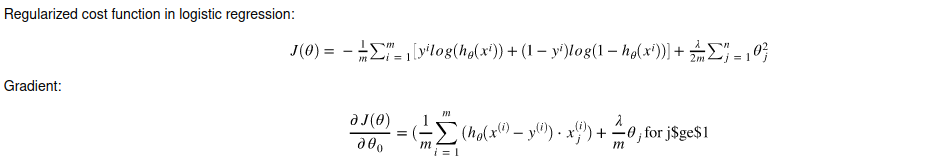

In [ ]:
def sigmoid(x):
    return 1. / (1. + np.exp(-x))

def cost_function_reg(theta, X, y, lambda_reg):
    m = y.shape[0]
    theta = theta[:, np.newaxis] 
    
    # forward
    h = sigmoid(X.dot(theta))
    
    # cost
    J = (1/m) * (-y.T.dot(np.log(h)) - (1-y).T.dot(np.log(1-h))) + (lambda_reg/(2*m)) * np.sum(theta[1:]**2)

    # backward
    dl = h - y
    grad = (1/m) * dl.T.dot(X) + ((lambda_reg/m) * theta.T)
    grad[0, 0] = (1/m) * dl.T.dot(X[:, 0])

    return J, grad[0]

<h1 id="preds" style="color:#5d3f40; background:#d0d1d3; border:0.5px dotted #5d3f40;"> 
    <center>Prediction/Accuracy functions
        <a class="anchor-link" href="#preds" target="_self">¶</a>
    </center>
</h1>

In [ ]:
def predict(X, theta):
    z = sigmoid(X.dot(theta))
    y_pred = [1 if z[i] >= 0.5
                 else 0 for i in range(len(z))]
    return y_pred

def accuracy(y_hat, y):
    return np.mean(y_hat == y)

<h1 id="params" style="color:#5d3f40; background:#d0d1d3; border:0.5px dotted #5d3f40;"> 
    <center>Hyperparameters
        <a class="anchor-link" href="#params" target="_self">¶</a>
    </center>
</h1>

In [ ]:
def reset(df):
    X = np.hstack((np.ones((df.shape[0],1)),df[['Age', 'EstimatedSalary']].values))
    y = np.array(df['Purchased'].values).reshape(-1,1)

    m = np.zeros(3)
    v = np.zeros(3)
    vhat = np.zeros(3)
    
    scale = 1/max(1., (2+2)/2.)
    limit = np.sqrt(3.0 * scale)
    theta = np.random.uniform(-limit, limit, size=(3))
    
    return theta, X, y ,m, v, vhat

In [ ]:
alpha = 0.1
beta1 = 0.9
beta2 = 0.99

nr_epochs = 100
batches = np.array_split(np.arange(len(df)), len(df) / 128)

<h1 id="train" style="color:#5d3f40; background:#d0d1d3; border:0.5px dotted #5d3f40;"> 
    <center>Training
        <a class="anchor-link" href="#train" target="_self">¶</a>
    </center>
</h1>

In [ ]:
lambda_reg = [0, 5, 10, 25]

best_acc = 0
best_params = {'theta': None}

for lambda_ in lambda_reg:
    
    theta, X, y, m, v, vhat = reset(df)
    
    costs = 0
    for t in range(nr_epochs):

        for b in batches:
            J, g = cost_function_reg(theta, X[b], y[b], lambda_)
            costs += J

            # AMSGrad optimizer
            for i in range(g.shape[0]):
                m[i] = beta1**(t+1) * m[i] + (1.0 - beta1**(t+1)) * g[i]
                v[i] = (beta2 * v[i]) + (1.0 - beta2) * g[i]**2
                vhat[i] = max(vhat[i], v[i])
                theta -= alpha * m[i] / (np.sqrt(vhat[i]) + 1e-8)

    y_hat = predict(X, theta)
    accs = accuracy(y_hat, y.reshape(-1))
            
    costs = costs / nr_epochs / len(batches)
    print("Lambda:%3d, Accuracy:%1.3f, Costs:%1.3f" % (lambda_, accs, costs))
    
    if(best_acc < accs):
        best_acc = accs
        best_params['theta'] = theta

<h1 id="results" style="color:#5d3f40; background:#d0d1d3; border:0.5px dotted #5d3f40;"> 
    <center>Analysis
        <a class="anchor-link" href="#results" target="_self">¶</a>
    </center>
</h1>

In [ ]:
y_hat = predict(X, best_params['theta'])
acc = accuracy(y_hat, y.reshape(-1))
print("Accuracy:%1.3f" % acc)

In [ ]:
# preds indexes for purchases
pred_zero = np.where(np.array(y_hat) == 0)[0].tolist()
pred_one = np.where(np.array(y_hat) == 1)[0].tolist()

plt.figure(figsize=(14,8))
plt.title("Age/Salary vs ADS Purchase")
plt.plot(df['Age'][pred_zero], df['EstimatedSalary'][pred_zero], 'bo', label='Not Purchased')
plt.plot(df['Age'][pred_one], df['EstimatedSalary'][pred_one], 'ro', label='Purchased')
plt.ylabel('Estimated Salary')
plt.xlabel('Age')
plt.legend()
plt.show()